Imports

In [1]:
import seaborn as sns
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from astropy.io import ascii
import astropy.io.fits as fits
import polTools
import os
import glob
from scipy.optimize import curve_fit
import lmfit
import xarray as xr

Seaborn

In [2]:
sns.set()
sns.set_style("white")
sns.set_context("paper", font_scale=1.0)
sns.set_style("ticks")

filePattern = '/*.fits'

Function defs

In [3]:
def viewstokes(stokes_Sw,err2_Sw,ok_w=[True],tcenter=0.):
    """Compute normalized stokes parameters, converts Q-U to P-T, for viewing
    Parameters
    ----------
    stokes_Sw: 2d float nparray(stokes,wavelength bin)
       unnormalized stokes parameters vs wavelength
    var_Sw: 2d float nparray(stokes,wavelength bin) 
       variance for stokes_sw
    ok_w: 1d boolean nparray(stokes,wavelength bin) 
       marking good stokes values. default all ok.
    Output: normalized stokes parameters and errors, linear stokes converted to pol %, PA
       Ignore covariance.  Assume binned first if necessary.
    """
    stokess,wavs = stokes_Sw.shape
    stokes_vw = np.zeros((stokess-1,wavs))
    err_vw = np.zeros((stokess-1,wavs))
    if (len(ok_w) == 1): ok_w = np.ones(wavs,dtype=bool)

    stokes_vw[:,ok_w] = 100.*stokes_Sw[1:,ok_w]/stokes_Sw[0,ok_w]               # in percent
    err_vw[:,ok_w] = 100.*np.sqrt(err2_Sw[1:stokess,ok_w])/stokes_Sw[0,ok_w]     # error bar ignores covariance

    if (stokess >2):
        stokesP_w = np.zeros((wavs))
        stokesT_w = np.zeros((wavs))
        varP_w = np.zeros((wavs))
        varT_w = np.zeros((wavs))
        varpe_dw = np.zeros((2,wavs))
        varpt_w = np.zeros((wavs))
        stokesP_w[ok_w] = np.sqrt(stokes_Sw[1,ok_w]**2 + stokes_Sw[2,ok_w]**2)      # unnormalized linear polarization
        stokesT_w[ok_w] = (0.5*np.arctan2(stokes_Sw[2,ok_w],stokes_Sw[1,ok_w]))     # PA in radians
        stokesT_w[ok_w] = (stokesT_w[ok_w]-(tcenter+np.pi/2.)+np.pi) % np.pi + (tcenter-np.pi/2.)
                                                                                    # optimal PA folding                
     # variance matrix eigenvalues, ellipse orientation
        varpe_dw[:,ok_w] = 0.5*(err2_Sw[1,ok_w]+err2_Sw[2,ok_w]                          \
            + np.array([1,-1])[:,None]*np.sqrt((err2_Sw[1,ok_w]-err2_Sw[2,ok_w])**2 + 4*err2_Sw[-1,ok_w]**2))
        varpt_w[ok_w] = 0.5*np.arctan2(2.*err2_Sw[-1,ok_w],err2_Sw[1,ok_w]-err2_Sw[2,ok_w])
     # linear polarization variance along p, PA   
        varP_w[ok_w] = varpe_dw[0,ok_w]*(np.cos(2.*stokesT_w[ok_w]-varpt_w[ok_w]))**2   \
               + varpe_dw[1,ok_w]*(np.sin(2.*stokesT_w[ok_w]-varpt_w[ok_w]))**2
        varT_w[ok_w] = varpe_dw[0,ok_w]*(np.sin(2.*stokesT_w[ok_w]-varpt_w[ok_w]))**2   \
               + varpe_dw[1,ok_w]*(np.cos(2.*stokesT_w[ok_w]-varpt_w[ok_w]))**2

        stokes_vw[0,ok_w] = 100*stokesP_w[ok_w]/stokes_Sw[0,ok_w]                  # normalized % linear polarization
        err_vw[0,ok_w] =  100*np.sqrt(err2_Sw[1,ok_w])/stokes_Sw[0,ok_w]
        stokes_vw[1,ok_w] = np.degrees(stokesT_w[ok_w])                            # PA in degrees
        err_vw[1,ok_w] =  0.5*np.degrees(np.sqrt(err2_Sw[2,ok_w])/stokesP_w[ok_w])

    return stokes_vw,err_vw

def binDataAngstrom(wave, stokes, goodData, error, binSize=10):
    binWavelength = (wave / binSize-0.5).astype(int) - int((wave / binSize-0.5).min())
    Bins = binWavelength.max()
    binWavelength[~goodData[1]] = -1
    
    stokesShape, empty = stokes.shape
    
    binArray = np.arange(Bins)
    binArrayOk = (binArray[:,None] == binWavelength[None,:])
    stokesBinned = (stokes[:,None,:] * binArrayOk).sum(axis=2)
    errorBinned = ((error[:stokesShape,None,:] + 2. * covar[:,None,:]) * binArrayOk).sum(axis=2)  
    wavelengthBinned = (wave[None,:] * binArrayOk).sum(axis=1) / binArrayOk.sum(axis=1)
    
    return stokesBinned, errorBinned, wavelengthBinned

def binDataError(wave, stokes, goodData, error, covar, bpm_Sw, binError=0.01):
    allowedgap = 5
    
    wgap0_g = np.where((bpm_Sw[0,:-1]==0) & (bpm_Sw[0,1:]!=0))[0] + 1
    wgap1_g = np.where((bpm_Sw[0,wgap0_g[0]:-1]!=0) & (bpm_Sw[0,wgap0_g[0]+1:]==0))[0] \
        +  wgap0_g[0] + 1
    wgap0_g = wgap0_g[0:wgap1_g.shape[0]]
    
    isbad_g = ((wgap1_g - wgap0_g) > allowedgap)
    
    stokes_sw, err_sw = viewstokes(stokes, error, ok_w=goodData,tcenter=np.pi/2)
    
    binvar_w = err_sw[0]**2
    bincovar_w = np.zeros_like(binvar_w)
    bincovar_w[goodData] = binvar_w[goodData]*covar[1,goodData]/error[1,goodData]
   
    ww = -1
    b = 0
    bin_w = -1*np.ones((wavs))
    
    while (bpm_Sw[0,ww+1:]==0).sum() > 0:
        
        w = ww+1+np.where(bpm_Sw[0,ww+1:]==0)[0][0]
        
        cumsvar_W = np.cumsum((binvar_w[w:]+2.*bincovar_w[w:])*(bpm_Sw[0,w:]==0))    \
                    /np.cumsum((bpm_Sw[0,w:]==0))**2
        
        err_W = np.sqrt(cumsvar_W)
        ww = wavs                                       # stopping point override: end
        
        nextbadgap = np.where(isbad_g & (wgap0_g > w))[0]
        
        if nextbadgap.size: ww = wgap0_g[nextbadgap[0]] - 1   # stopping point override: before bad gap
        
        dw = np.where(err_W[:ww-w] < binError)[0]
        
        if dw.size: ww = w + dw[0]                      # err goal is reached first
            
        binWavelength[w:ww+1] = b
        b += 1
        
    binWavelength[bpm_Sw[0]>0] = -1
    Bins  = b
    
    stokesShape, empty = stokes.shape
    
    binArray = np.arange(Bins)
    binArrayOk = (binArray[:,None] == binWavelength[None,:])
    stokesBinned = (stokes[:,None,:]*binArrayOk).sum(axis=2)
    errorBinned = ((error[:stokesShape,None,:] + 2.*covar[:,None,:])*binArrayOk).sum(axis=2)  
    wavelengthBinned = (wave[None,:]*binArrayOk).sum(axis=1)/binArrayOk.sum(axis=1)
    
    return stokesBinned, errorBinned, wavelengthBinned

In [4]:
def fileLoad(folder):
    '''Loads a fits file'''
    dataFile = glob.glob(folder+filePattern)

    #Open fits file
    with fits.open(dataFile[0]) as hdul:

       # stokes I, Q, U values in [0, :], [1, :], [2, :]
        stokesSw = hdul['SCI'].data[:,0,:]
        #stokes errors (I, Q, U)
        varSw = hdul['VAR'].data[:,0,:]
        covarSw = hdul['COV'].data[:,0,:]
        deltaWave = float(hdul['SCI'].header['CDELT1'])
        #get starting wavelength
        wave0 = float(hdul['SCI'].header['CRVAL1'])
        #get wavelength axis size
        waves = int(hdul['SCI'].header['NAXIS1'])

        bpm_Sw = hdul['BPM'].data[:,0,:]
        ok_Sw = (bpm_Sw==0)

        wavelengths = wave0 + deltaWave*np.arange(waves)

        return stokesSw, varSw, covarSw, wavelengths, ok_Sw, bpm_Sw

def readData(fileName):
    data = []
    dataError = []
    dataCovar = []
    dataWave = []
    dataOk = []
    dataBPM = []

    #folder = "F:/Andrew's Dropbox/Dropbox/"
    folder = "D:/Dropbox/"
    fileNameTotal = folder + fileName
    
    folderList = glob.glob(fileNameTotal)
    
    for folder in folderList:
        print(folder)
        stokes, stokesError, stokesCovar, waves, ok, bpm = fileLoad(folder)
        data.append(stokes)
        dataError.append(stokesError)
        dataCovar.append(stokesCovar)
        dataWave.append(waves)
        dataOk.append(ok)
        dataBPM.append(bpm)
  
    return data, dataError, dataCovar, dataWave, dataOk, dataBPM

C:\Users\Andrew\Anaconda3\lib\site-packages\numpy\polynomial\polynomial.py:1336: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)


(3500, 10500)

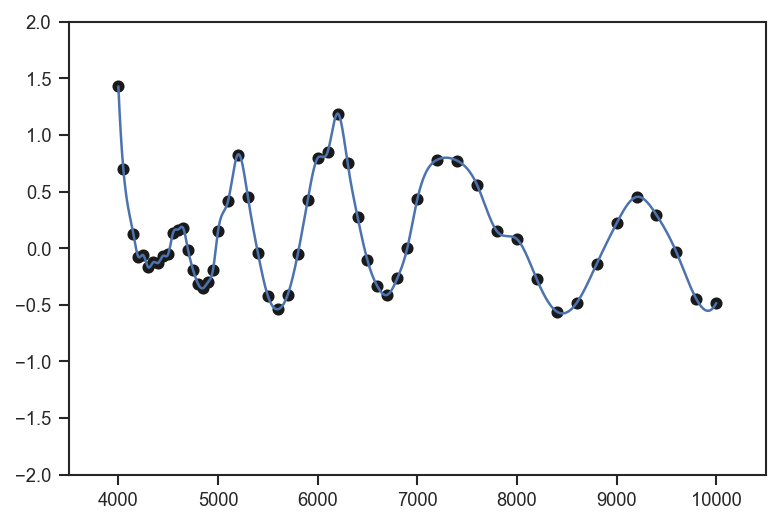

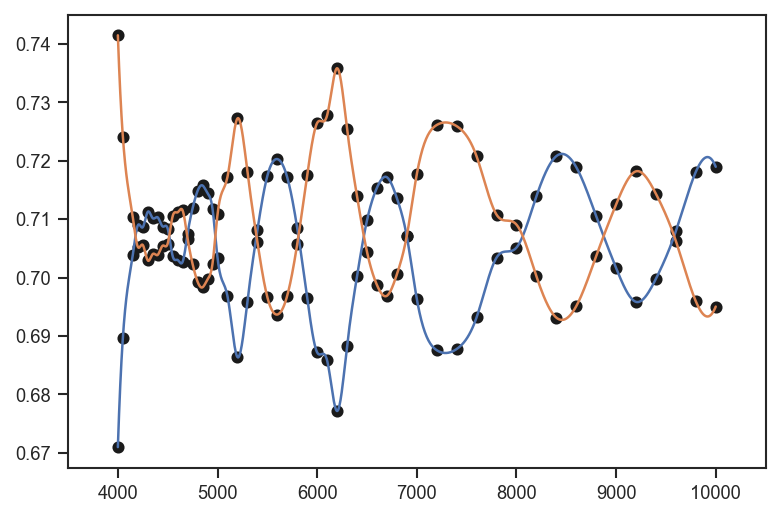

In [5]:
fig, ax = plt.subplots(figsize = (6,4), dpi=150)

ripple = ascii.read("PA_Ripple.txt", data_start=2)

ripple_interp = np.polynomial.polynomial.polyfit(ripple["wavl"][(ripple["wavl"] > 4100) & (ripple["wavl"]<7800)], ripple["dPA"][(ripple["wavl"] > 4100) & (ripple["wavl"]<7800)], deg=15)
ripple_interp2 = sp.interpolate.interp1d(ripple["wavl"], ripple["dPA"], kind='cubic', fill_value='extrapolate')

wavs = np.linspace(4000, 10000, 1000)
#pp = sp.interpolate.PPoly.from_spline(ripple_interp2)

ax.plot(ripple["wavl"], ripple["dPA"], "ko")
ax.plot(wavs, ripple_interp2(wavs))
#ax.plot(wavs, np.polyval(ripple_interp[::-1], wavs))
#ax.plot(wavs, sp.interpolate.splev(wavs, ripple_interp2))
#ax.plot([4300, 4600, 4850, 5200, 5600, 6150, 6650, 7000, 8600, 9180], np.ones(10), "rx")
ax.set_xlim(3500, 10500)
ax.set_ylim(-2, 2)


fig, ax = plt.subplots(figsize = (6,4), dpi=150)

ripple = ascii.read("PA_Ripple.txt", data_start=2)

q_ripple = np.cos(2 * np.deg2rad(ripple["dPA"]+22.5))
u_ripple = np.sin(2 * np.deg2rad(ripple["dPA"]+22.5))

ripple_q_interp = sp.interpolate.interp1d(ripple["wavl"], q_ripple, kind='cubic', fill_value='extrapolate')
ripple_u_interp = sp.interpolate.interp1d(ripple["wavl"], u_ripple, kind='cubic', fill_value='extrapolate')

ax.plot(ripple["wavl"], q_ripple, "ko")
ax.plot(ripple["wavl"], u_ripple, "ko")
ax.plot(wavs, ripple_q_interp(wavs))
ax.plot(wavs, ripple_u_interp(wavs))
ax.set_xlim(3500, 10500)
#ax.set_ylim(-2, 2)


In [31]:
import lmfit

def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(y), lambda z: z.nonzero()[0]

def fitting_poly(params, x, q=None, qerr=None, u=None, uerr=None, size=300):
    
    model_q = np.zeros((len(q), size))
    model_u = np.zeros((len(u), size))
    i=0
    
    for i in range(len(q)):
        model_q[i] = params["A_%i"%(i+1)] * np.cos(2 * np.deg2rad(ripple_interp2(x[i] + params["x"]) + params["rot_%i"%(i+1)])) \
        + params["q00_%i"%(i+1)] + params["P_max"] * np.cos(2 * (params["theta0"] + params["k"] * 1./(x[i]*1e-4))) \
        * np.exp(-1.7 * params["lambda_max"] * np.log(params["lambda_max"] * 1./(x[i]*1e-4))**2)

        model_u[i] = params["A_%i"%(i+1)] * np.sin(2 * np.deg2rad(ripple_interp2(x[i] + params["x"]) + params["rot_%i"%(i+1)])) \
        + params["u00_%i"%(i+1)] + params["P_max"] * np.sin(2 * (params["theta0"] + params["k"] * 1./(x[i]*1e-4))) \
        * np.exp(-1.7 * params["lambda_max"] * np.log(params["lambda_max"] * 1./(x[i]*1e-4))**2)

    if q is None:
        return model_q, model_u
    
    residual_q = np.zeros((len(q), size))
    residual_u = np.zeros((len(u), size))
    
    weighted_q = np.zeros((len(q), size))
    weighted_u = np.zeros((len(u), size))
    
    for i, date in enumerate(q):
        residual_q[i] = date - model_q[i]
        weighted_q[i] = np.sqrt(residual_q[i]**2/qerr[i]**2)
    
    for i, date in enumerate(u):
        residual_u[i] = date - model_u[i]
        weighted_u[i] = np.sqrt(residual_u[i]**2/uerr[i]**2) 
        
    return np.concatenate((weighted_q.flatten(), weighted_u.flatten()))

def fitting_isp(params, x, q=None, qerr=None, u=None, uerr=None, size= 309):
    
    model_q = np.zeros((len(q), size))
    model_u = np.zeros((len(u), size))
    i=0
    
    for i in range(len(q)):
        model_q[i] = params["q00_%i"%(i+1)] + params["P_max"] * np.cos(2 * (params["theta0"] + params["k"] * 1./(x[i]*1e-4))) \
        * np.exp(-1.7 * params["lambda_max"] * np.log(params["lambda_max"] * 1./(x[i]*1e-4))**2)

        model_u[i] = params["u00_%i"%(i+1)] + params["P_max"] * np.sin(2 * (params["theta0"] + params["k"] * 1./(x[i]*1e-4))) \
        * np.exp(-1.7 * params["lambda_max"] * np.log(params["lambda_max"] * 1./(x[i]*1e-4))**2)

    if q is None:
        return model_q, model_u
    
    residual_q = np.zeros((len(q), size))
    residual_u = np.zeros((len(u), size))
    
    weighted_q = np.zeros((len(q), size))
    weighted_u = np.zeros((len(u), size))
    
    for i, date in enumerate(q):
        residual_q[i] = date - model_q[i]
        weighted_q[i] = np.sqrt(residual_q[i]**2/qerr[i]**2)
    
    for i, date in enumerate(u):
        residual_u[i] = date - model_u[i]
        weighted_u[i] = np.sqrt(residual_u[i]**2/uerr[i]**2) 
        
    return np.concatenate((weighted_q.flatten(), weighted_u.flatten()))


def fitting_poly_q_i(params, x, i):
    
    model_q = params["A_%i"%(i+1)]*np.cos(2 * np.deg2rad(ripple_interp2(x + params["x"]) + params["rot_%i"%(i+1)])) \
    + params["q00_%i"%(i+1)] + params["P_max"] * np.cos(2 * (params["theta0"] + params["k"] * 1./(x*1e-4))) \
    * np.exp(-1.7 * params["lambda_max"] * np.log(params["lambda_max"] * 1./(x*1e-4))**2)

    return model_q
 
def fitting_poly_u_i(params, x, i):
    
    model_u = params["A_%i"%(i+1)]*np.sin(2 * np.deg2rad(ripple_interp2(x + params["x"]) + params["rot_%i"%(i+1)])) \
    + params["u00_%i"%(i+1)] + params["P_max"] * np.sin(2 * (params["theta0"] + params["k"] * 1./(x*1e-4))) \
    * np.exp(-1.7 * params["lambda_max"] * np.log(params["lambda_max"] * 1./(x*1e-4))**2)

    return model_u

def fitting_q_isp_i(params, x, i):
    
    model_q = params["q00_%i"%(i+1)] + params["P_max"] * np.cos(2 * (params["theta0"] + params["k"] * 1./(x*1e-4))) \
    * np.exp(-1.7 * params["lambda_max"] * np.log(params["lambda_max"] * 1./(x*1e-4))**2)

    return model_q
 
def fitting_u_isp_i(params, x, i):
    
    model_u = params["u00_%i"%(i+1)] + params["P_max"] * np.sin(2 * (params["theta0"] + params["k"] * 1./(x*1e-4))) \
    * np.exp(-1.7 * params["lambda_max"] * np.log(params["lambda_max"] * 1./(x*1e-4))**2)

    return model_u
    
qu_table = []

wavelengthBinned = np.linspace(4200, 7250, 300)

for i in range(10):
    
    q_noise = np.random.normal(0,0.02,300)
    u_noise = np.random.normal(0,0.02,300)
    
    A = 1.5*np.random.random()
    
    print(A)
    
    q = q_noise + A*np.cos(2 * np.deg2rad(ripple_interp2(wavelengthBinned-90) + 60))
    u = u_noise + A*np.sin(2 * np.deg2rad(ripple_interp2(wavelengthBinned-90) + 60))
    
    q_err = q_noise
    u_err = u_noise
    
    q +=  2.0 + 4.0 * np.cos(2 * (np.pi/2 + 0.0 * 1./(wavelengthBinned*1e-4))) \
        * np.exp(-1.7 * 0.5 * np.log(0.5 * 1./(wavelengthBinned*1e-4))**2)
    
    u += - 1.0 + 4.0 * np.sin(2 * (np.pi/2 + 0.0 * 1./(wavelengthBinned*1e-4))) \
        * np.exp(-1.7 * 0.5 * np.log(0.5 * 1./(wavelengthBinned*1e-4))**2)
    
    qu_da = np.array((wavelengthBinned, q, q_err, u, u_err))
    
    qu_table.append(qu_da)

qu_table = np.stack(qu_table)
    
qu_da2 = xr.DataArray(qu_table, dims=['date', 'data', 'rows'], coords={'data': ['wavelength', 'q', 'qerr', 'u', 'uerr']})

par = lmfit.Parameters()
for i in range(len(qu_da2.loc[:, 'q'])):    
    par.add('A_%i'%(i+1), value = 1.5,min=0)
    par.add('rot_%i'%(i+1), value = 60.0)
    par.add('q00_%i'%(i+1), value = np.mean(qu_da2.loc[i, 'q']))
    par.add('u00_%i'%(i+1), value = np.mean(qu_da2.loc[i, 'u']))
    
par.add('x', value = -90.0, min=-200, max=200)
par.add('P_max', value = 1.0)
par.add('theta0', value = 0)
par.add('k', value=0.0)
par.add('lambda_max', value = 0.5)
    
mini = lmfit.Minimizer(fitting_poly, par, fcn_args=(qu_da2.loc[:, 'wavelength'],), \
                       fcn_kws={'q':qu_da2.loc[:, 'q'], 'qerr':qu_da2.loc[:, 'qerr'], 'u':qu_da2.loc[:, 'u'], 'uerr':qu_da2.loc[:, 'uerr']}, nan_policy='omit')
    
out = mini.minimize()

1.3291023928092587
0.292192124603953
0.6010763448108759
1.1136575895121188
0.35446267079969324
1.2815695559905718
0.7276089954421754
1.189317100538744
0.16128511333368073
1.1118832149255549


[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 231
    # data points      = 6000
    # variables        = 45
    chi-square         = 5967.32561
    reduced chi-square = 1.00206979
    Akaike info crit   = 57.2363131
    Bayesian info crit = 358.714477
[[Variables]]
    A_1:         1.32260152 +/- 0.00572421 (0.43%) (init = 1.5)
    rot_1:       60.0079007 +/- 0.14622895 (0.24%) (init = 60)
    q00_1:       1.99821636 +/- 0.00726442 (0.36%) (init = -2.539043)
    u00_1:      -0.99484114 +/- 0.00529050 (0.53%) (init = 0.1487658)
    A_2:         0.30298473 +/- 0.00796034 (2.63%) (init = 1.5)
    rot_2:       61.5068724 +/- 1.06562082 (1.73%) (init = 60)
    q00_2:       2.02013934 +/- 0.01310107 (0.65%) (init = -2.016604)
    u00_2:      -1.00182231 +/- 0.00459107 (0.46%) (init = -0.7483688)
    A_3:         0.59761157 +/- 0.00489320 (0.82%) (init = 1.5)
    rot_3:       59.9862285 +/- 0.15792661 (0.26%) (init = 60)
    q00_3:       1.99914714 +/- 0.0022022

Text(0.5, 0, 'Wavelength')

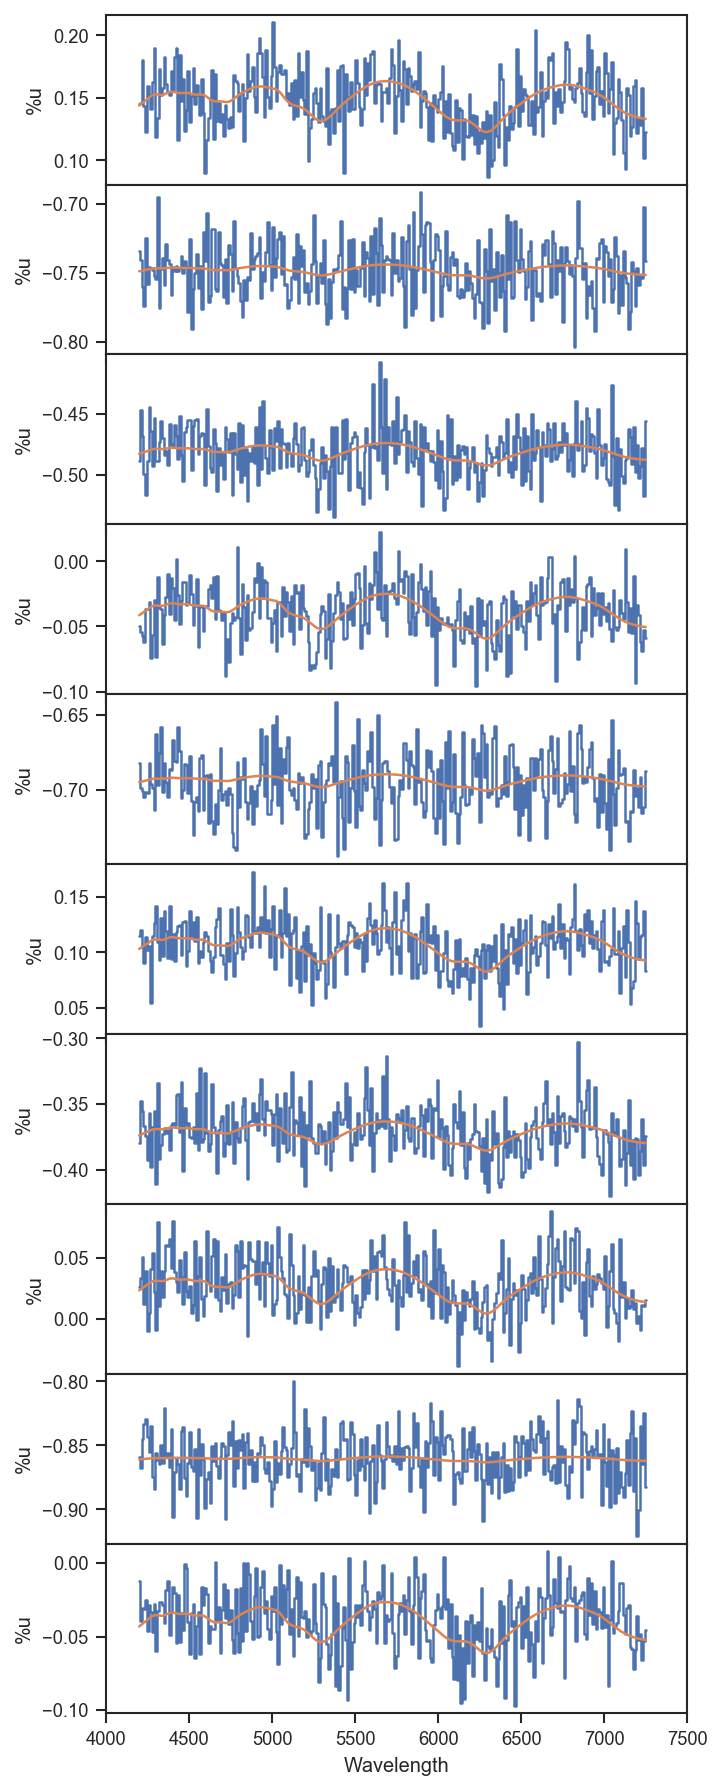

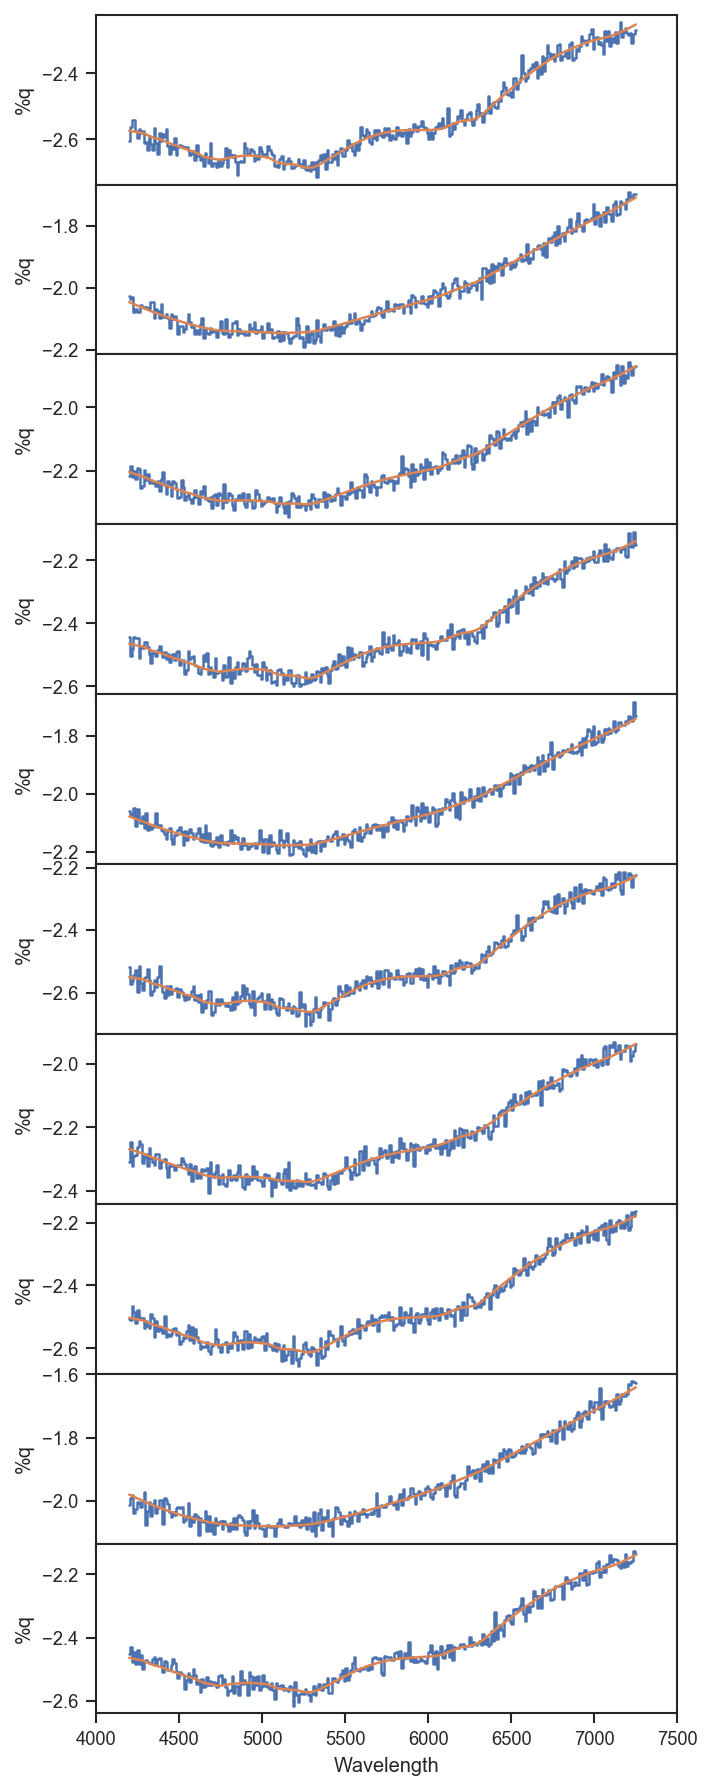

In [32]:
print(lmfit.fit_report(out, min_correl=2))

wavs = np.linspace(4200, 7250, 1000)

fig, subplots = plt.subplots(10, 1, figsize = (5, 15), sharex=True, dpi=150)

fig.subplots_adjust(hspace=0.0)

for i in range(len(qu_da2.loc[:, 'u'])):
    ax = subplots.flat[i]
    ax.step(qu_da2.loc[i, 'wavelength'], qu_da2.loc[i, 'u'], where='mid')
    ax.plot(wavs, fitting_poly_u_i(out.params, wavs, i))
    ax.set_xlim(4000, 7500)
    ax.set_ylabel('%u')
    
ax.set_xlabel('Wavelength')

fig, subplots = plt.subplots(10, 1, figsize = (5, 15), sharex=True, dpi=150)

fig.subplots_adjust(hspace=0.0)    
    
for i in range(len(qu_da2.loc[:, 'q'])):
    ax = subplots.flat[i]
    ax.step(qu_da2.loc[i, 'wavelength'], qu_da2.loc[i, 'q'], where='mid')
    ax.plot(wavs, fitting_poly_q_i(out.params, wavs, i))
    ax.set_xlim(4000, 7500)
    ax.set_ylabel('%q')
    
ax.set_xlabel('Wavelength')

Text(0.5, 0, 'Wavelength')

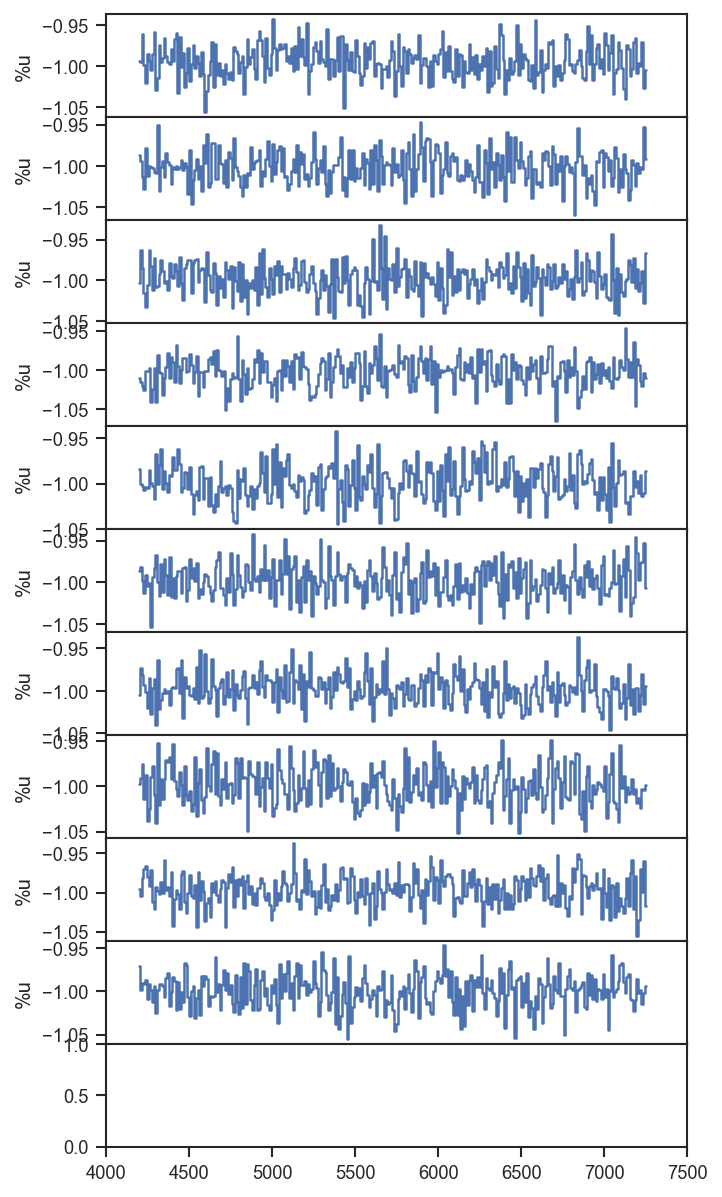

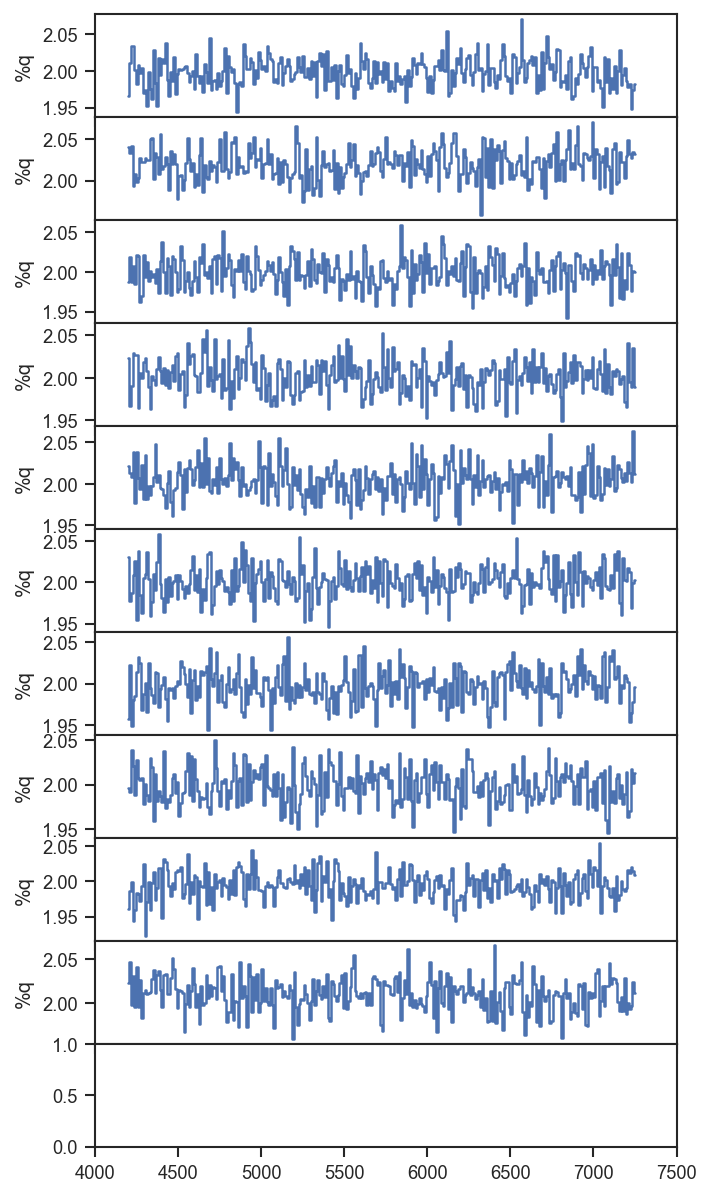

In [33]:
fig, subplots = plt.subplots(11, 1, figsize = (5, 10), sharex=True, dpi=150)

for i in range(len(qu_da2.loc[:, 'q'])):    
    out.params['q00_%i'%(i+1)].set(0.0)
    out.params['u00_%i'%(i+1)].set(0.0)

fig.subplots_adjust(hspace=0.0)

for i in range(len(qu_da2.loc[:, 'u'])):
    ax = subplots.flat[i]
    ax.step(qu_da2.loc[i, 'wavelength'], qu_da2.loc[i, 'u'] - fitting_poly_u_i(out.params, qu_da2.loc[i, 'wavelength'], i), where='mid')
    ax.set_xlim(4000, 7500)
    ax.set_ylabel('%u')
    
ax.set_xlabel('Wavelength')

fig, subplots = plt.subplots(11, 1, figsize = (5, 10), sharex=True, dpi=150)

fig.subplots_adjust(hspace=0.0)    
    
for i in range(len(qu_da2.loc[:, 'q'])):
    ax = subplots.flat[i]
    ax.step(qu_da2.loc[i, 'wavelength'], qu_da2.loc[i, 'q'] - fitting_poly_q_i(out.params, qu_da2.loc[i, 'wavelength'], i), where='mid')
    ax.set_xlim(4000, 7500)
    ax.set_ylabel('%q')
    
ax.set_xlabel('Wavelength')